# Import Package & Download Dataset

In [1]:
# imports

import scipy
import urllib.request
import pandas as pd
from pandas.plotting import parallel_coordinates
import numpy as np
import seaborn as sns
import math
import random
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.gofplots as smg
import statsmodels.stats.multitest as multitest
from statsmodels.sandbox.stats.multicomp import multipletests


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# Download Dataset
dataset = "/content/drive/MyDrive/dataset/BioInformatic/S5.xlsx"
urllib.request.urlretrieve("http://science.sciencemag.org/highwire/filestream/680254/field_highwire_adjunct_files/5/aad0189_DataFileS5.xlsx", dataset)


('/content/drive/MyDrive/dataset/BioInformatic/S5.xlsx',
 <http.client.HTTPMessage at 0x7ff84e6b9090>)

# Data Wrangling

In [7]:
s5 = pd.read_excel(dataset, skiprows=2, index_col=0)
s5.head()


,MATCH_ORDER,Gene,Probeset,Gene.1,Protein,Unnamed: 6,Range CD,Range HFD,Range_All,C57BL/6J_Liver_CD,DBA/2J_Liver_CD,BXD43_Liver_CD,BXD44_Liver_CD,BXD45_Liver_CD,BXD48_Liver_CD,BXD49_Liver_CD,BXD51_Liver_CD,BXD55_Liver_CD,BXD56_Liver_CD,BXD60_Liver_CD,BXD61_Liver_CD,BXD62_Liver_CD,BXD63_Liver_CD,BXD64_Liver_CD,BXD65_Liver_CD,BXD66_Liver_CD,BXD68_Liver_CD,BXD69_Liver_CD,BXD70_Liver_CD,BXD71_Liver_CD,BXD73_Liver_CD,BXD75_Liver_CD,BXD79_Liver_CD,BXD80_Liver_CD,BXD81_Liver_CD,BXD83_Liver_CD,BXD84_Liver_CD,BXD85_Liver_CD,BXD87_Liver_CD,BXD89_Liver_CD,...,C57BL/6J_Liver_HFD,DBA/2J_Liver_HFD,BXD43_Liver_HFD,BXD44_Liver_HFD,BXD45_Liver_HFD,BXD48_Liver_HFD,BXD49_Liver_HFD,BXD50_Liver_HFD,BXD51_Liver_HFD,BXD55_Liver_HFD,BXD56_Liver_HFD,BXD61_Liver_HFD,BXD62_Liver_HFD,BXD63_Liver_HFD,BXD64_Liver_HFD,BXD65_Liver_HFD,BXD66_Liver_HFD,BXD68_Liver_HFD,BXD69_Liver_HFD,BXD70_Liver_HFD,BXD71_Liver_HFD,BXD73_Liver_HFD,BXD75_Liver_HFD,BXD79_Liver_HFD,BXD80_Liver_HFD,BXD81_Liver_HFD,BXD83_Liver_HFD,BXD84_Liver_HFD,BXD85_Liver_HFD,BXD87_Liver_HFD,BXD89_Liver_HFD,BXD90_Liver_HFD,BXD95_Liver_HFD,BXD96_Liver_HFD,BXD97_Liver_HFD,BXD98_Liver_HFD,BXD99_Liver_HFD,BXD100_Liver_HFD,BXD101_Liver_HFD,BXD103_Liver_HFD
Original_Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12643,NaN,Igh,10403036,Igh,0,NaN,1.495886,1.720705,1.720705,5.138,5.296,5.061,4.964,4.920,5.151,5.054,4.963,4.946,4.922,4.808,5.006,5.328,5.059,4.962,4.747,5.160,5.032,5.074,4.933,5.075,4.818,5.129,5.092,5.032,5.033,4.941,5.197,4.983,4.890,5.057,...,5.511,4.728,5.191,5.024,4.960,4.973,4.989,4.914,4.869,4.973,4.848,5.284,5.099,5.046,5.213,5.076,4.998,5.184,5.401,5.006,5.102,4.842,5.066,4.961,4.800,5.143,5.076,5.095,5.346,4.805,4.959,5.483,5.347,5.087,5.125,5.160,5.020,5.170,4.775,4.982
12646,NaN,Igh,10403043,Igh,0,NaN,2.938337,1.988940,3.595021,7.983,7.529,7.645,7.697,7.892,7.514,7.964,7.866,7.733,7.674,7.694,8.854,7.882,7.599,7.683,7.625,7.541,7.700,7.659,8.024,7.541,7.765,7.712,7.299,7.764,7.994,7.963,7.772,7.513,7.444,7.583,...,7.927,7.421,7.526,7.616,7.727,7.997,8.000,7.481,7.454,7.384,7.480,7.506,7.568,7.884,7.376,7.455,7.396,7.591,7.676,7.185,7.412,7.506,7.508,7.353,7.493,7.708,7.244,7.379,7.225,7.008,7.415,7.252,7.547,7.358,7.424,7.447,7.567,7.732,7.365,7.369
12653,NaN,Igh,10403063,Igh,0,NaN,3.719220,1.859610,4.260433,7.169,7.023,7.083,6.979,7.031,6.880,7.145,7.394,6.978,7.073,7.255,8.520,6.625,6.631,7.292,6.844,7.087,6.803,6.664,7.012,6.779,7.066,7.028,7.117,6.944,7.318,6.939,6.824,7.010,6.834,7.145,...,7.324,6.948,6.905,6.558,6.848,6.901,7.074,6.526,6.944,6.742,6.429,6.496,6.942,6.826,6.867,6.770,6.687,6.848,6.873,6.878,6.762,6.951,6.500,6.843,6.836,7.064,6.836,6.886,6.575,6.575,6.665,6.948,6.999,6.974,6.886,6.876,7.027,7.093,6.748,6.771
8759,1458.0,Hcfc2,10365242,Hcfc2,A0AUN4,NaN,1.479388,1.465101,1.536875,9.241,8.990,8.967,8.681,8.894,8.865,9.133,8.822,8.976,9.004,8.955,8.850,9.077,8.910,9.153,8.990,9.070,9.246,9.002,8.848,9.062,8.826,9.141,9.097,9.045,8.972,9.031,9.140,9.159,9.195,8.964,...,8.897,9.140,8.965,8.829,8.750,8.732,9.041,8.918,8.726,8.994,8.924,8.800,8.739,8.947,8.990,8.924,9.019,8.626,8.664,8.722,8.664,8.900,9.014,8.885,9.032,8.905,8.777,8.871,8.957,8.963,9.177,9.021,8.803,8.928,8.914,8.838,9.056,8.924,8.945,8.865
18740,8191.0,Ccdc112,10458794,Ccdc112,A0AUP1,NaN,1.834008,1.943962,1.997229,6.761,6.656,6.729,6.813,6.739,6.888,7.064,6.970,6.959,6.548,6.883,7.063,6.901,6.290,6.573,7.010,6.866,6.830,6.892,6.842,6.959,6.854,6.833,6.999,6.887,6.798,6.977,6.726,6.757,6.830,6.775,...,6.502,6.484,6.706,6.565,6.519,6.466,6.523,6.495,6.448,7.126,6.369,6.568,6.379,6.444,6.536,6.428,6.478,6.422,6.618,6.608,6.584,6.447,6.417,6.658,6.420,6.513,6.287,6.339,6.415,6.515,6.623,6.371,6.187,6.310,6.448,6.531,6.167,6.401,6.470,6.565


In [8]:
#Take a quick look at the means to get a rough idea if the data is already normalized
s5.mean()

MATCH_ORDER         9.545500e+03
Probeset            1.045421e+07
Unnamed: 6                   NaN
Range CD            2.368464e+00
Range HFD           2.189771e+00
                        ...     
BXD98_Liver_HFD     7.999999e+00
BXD99_Liver_HFD     7.999998e+00
BXD100_Liver_HFD    7.999998e+00
BXD101_Liver_HFD    8.000003e+00
BXD103_Liver_HFD    7.999999e+00
Length: 88, dtype: float64

Average over different probesets for a gene and generate a dataframe containing each gene symbol (once) as rows and the corresponding averaged expression values for each strain + condition as columns

In [9]:
s5_filtered = s5.drop(['Unnamed: 6'], axis=1)
s5grouped = s5_filtered.groupby(['Gene.1']).mean()

s5grouped.head()

,MATCH_ORDER,Probeset,Range CD,Range HFD,Range_All,C57BL/6J_Liver_CD,DBA/2J_Liver_CD,BXD43_Liver_CD,BXD44_Liver_CD,BXD45_Liver_CD,BXD48_Liver_CD,BXD49_Liver_CD,BXD51_Liver_CD,BXD55_Liver_CD,BXD56_Liver_CD,BXD60_Liver_CD,BXD61_Liver_CD,BXD62_Liver_CD,BXD63_Liver_CD,BXD64_Liver_CD,BXD65_Liver_CD,BXD66_Liver_CD,BXD68_Liver_CD,BXD69_Liver_CD,BXD70_Liver_CD,BXD71_Liver_CD,BXD73_Liver_CD,BXD75_Liver_CD,BXD79_Liver_CD,BXD80_Liver_CD,BXD81_Liver_CD,BXD83_Liver_CD,BXD84_Liver_CD,BXD85_Liver_CD,BXD87_Liver_CD,BXD89_Liver_CD,BXD90_Liver_CD,BXD92_Liver_CD,BXD95_Liver_CD,BXD96_Liver_CD,...,C57BL/6J_Liver_HFD,DBA/2J_Liver_HFD,BXD43_Liver_HFD,BXD44_Liver_HFD,BXD45_Liver_HFD,BXD48_Liver_HFD,BXD49_Liver_HFD,BXD50_Liver_HFD,BXD51_Liver_HFD,BXD55_Liver_HFD,BXD56_Liver_HFD,BXD61_Liver_HFD,BXD62_Liver_HFD,BXD63_Liver_HFD,BXD64_Liver_HFD,BXD65_Liver_HFD,BXD66_Liver_HFD,BXD68_Liver_HFD,BXD69_Liver_HFD,BXD70_Liver_HFD,BXD71_Liver_HFD,BXD73_Liver_HFD,BXD75_Liver_HFD,BXD79_Liver_HFD,BXD80_Liver_HFD,BXD81_Liver_HFD,BXD83_Liver_HFD,BXD84_Liver_HFD,BXD85_Liver_HFD,BXD87_Liver_HFD,BXD89_Liver_HFD,BXD90_Liver_HFD,BXD95_Liver_HFD,BXD96_Liver_HFD,BXD97_Liver_HFD,BXD98_Liver_HFD,BXD99_Liver_HFD,BXD100_Liver_HFD,BXD101_Liver_HFD,BXD103_Liver_HFD
Gene.1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
544988,NaN,10417445.0,1.495780,1.366581,1.517264,6.1830,6.353333,6.262333,6.263667,6.270,6.201333,6.2370,6.274667,6.319,6.2710,6.329333,6.3150,6.190333,6.2890,6.223667,6.330667,6.278667,6.201667,6.270667,6.2550,6.331333,6.366333,6.318333,6.2630,6.207,6.228667,6.396667,6.279333,6.6340,6.3360,6.300667,6.274667,6.315,6.3450,6.283,...,6.365333,6.348333,6.301333,6.345667,6.350667,6.285667,6.207667,6.310333,6.362667,6.474667,6.427333,6.3660,6.2800,6.249667,6.277333,6.303333,6.2020,6.296333,6.430,6.374667,6.438333,6.355333,6.415667,6.210667,6.393333,6.334333,6.4720,6.4150,6.3430,6.1480,6.364333,6.339333,6.397667,6.3280,6.280333,6.385333,6.460667,6.331667,6.216667,6.278333
100043387,NaN,10490273.0,2.145033,2.118437,2.388326,10.3840,9.848000,10.108000,9.860000,9.392,9.926000,10.1050,10.040000,10.128,9.4100,10.156000,10.4100,9.797000,9.3830,10.298000,9.837000,10.422000,10.374000,10.385000,10.2010,10.014000,10.125000,10.069000,10.3370,9.937,9.980000,10.276000,9.997000,9.9170,10.0170,10.091000,10.015000,10.150,10.4840,10.306,...,10.215000,10.153000,10.361000,10.044000,9.736000,10.108000,10.195000,10.074000,10.155000,9.979000,9.786000,10.1130,9.9020,10.233000,10.230000,10.416000,10.3520,10.035000,10.072,10.290000,10.261000,10.308000,10.312000,10.278000,9.997000,10.161000,9.9700,9.6810,10.2550,10.3230,10.088000,10.553000,9.556000,10.6320,10.427000,10.217000,10.140000,10.639000,10.223000,9.956000
0610007C21Rik,12730.0,10520638.0,1.368884,1.404445,1.427015,12.3890,12.559000,12.647000,12.639000,12.515,12.659000,12.5710,12.512000,12.651,12.5290,12.498000,12.5170,12.607000,12.3620,12.491000,12.632000,12.707000,12.607000,12.580000,12.6320,12.802000,12.667000,12.749000,12.6130,12.622,12.685000,12.556000,12.585000,12.6030,12.5800,12.815000,12.761000,12.679,12.4730,12.583,...,12.521000,12.611000,12.626000,12.527000,12.703000,12.671000,12.439000,12.618000,12.656000,12.302000,12.617000,12.6380,12.6360,12.460000,12.539000,12.632000,12.6190,12.739000,12.695,12.599000,12.705000,12.684000,12.599000,12.726000,12.624000,12.741000,12.6300,12.5640,12.5060,12.4160,12.608000,12.593000,12.792000,12.5730,12.690000,12.700000,12.628000,12.550000,12.660000,12.696000
0610007L01Rik,13092.0,10530142.5,1.391366,1.395395,1.444313,10.2875,10.390000,10.411000,10.419500,10.306,10.432000,10.2005,10.432000,10.320,10.2945,10.146500,10.0750,10.267000,10.2500,10.230000,10.215000,10.311000,10.272500,10.335000,10.2825,10.295500,10.305000,10.302000,10.3165,10.216,10.251000,10.361500,10.230500,10.2730,10.2845,10.354000,10.320000,10.340,10.2595,10.215,...,10.334500,10.363000,10.401500,10.326000,10.404000,10.231500,10.221500,10.218000,10.357000,10.357000,10.283000,10.2020,10.2055,10.264500,1

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


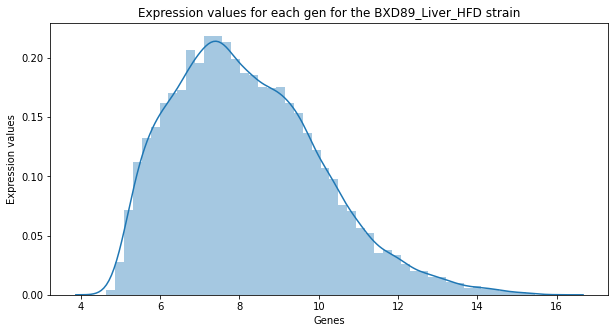

In [10]:
#Check the histogram for distribution 
fig, ax = plt.subplots(figsize=(10,5))

hplot = sns.distplot(s5grouped['BXD89_Liver_HFD'])

plt.title('Expression values for each gen for the BXD89_Liver_HFD strain')
plt.xlabel('Genes', fontsize= 10)
plt.ylabel('Expression values', fontsize= 10)

plt.show()


A good way to check if the data is already log'ed is to take a look at the histogram. As we can see, at least the BXD89_Liver_HFD data is still normal distributed, therefore has not ben logged transformed yet

Another way is to look at the mean and medians of the datasets. For normal distributions, those two should be close together, while for log normal distributions they can differ alot.



In [11]:
#Compare mean from above with median computed here:
s5.median()


MATCH_ORDER         9.545500e+03
Probeset            1.044955e+07
Unnamed: 6                   NaN
Range CD            1.788810e+00
Range HFD           1.715941e+00
                        ...     
BXD98_Liver_HFD     7.726000e+00
BXD99_Liver_HFD     7.730000e+00
BXD100_Liver_HFD    7.746000e+00
BXD101_Liver_HFD    7.737000e+00
BXD103_Liver_HFD    7.758500e+00
Length: 88, dtype: float64

Quantile normalization: carry out a quantile normalization of the data (or not)

> Implement a ratio intensity plot (using matplotlib)


In [12]:
#Filter out some of the cols
s5grouped_filtered = s5grouped.drop(['MATCH_ORDER', 'Probeset', 'Range CD', 'Range HFD', 'Range_All', 'Unnamed: 51'], 1)


In [13]:
#Ratio-Intensity plot

def ratio_intensity_plot(s1, s2):
    x = (s5grouped_filtered[s1]+s5grouped_filtered[s2])/2
    y = s5grouped_filtered[s1]-s5grouped_filtered[s2]
    lowess = sm.nonparametric.lowess(y, x, frac = 0.2)
    
    plt.plot([min(x), max(y)], [0,0], color="green")
    plt.scatter(x,y)
    plt.plot(lowess[:, 0], lowess[:, 1], color="red")

    plt.show()


> Apply your ratio intensity plot to several pairs of chips (columns of your above dataframe)


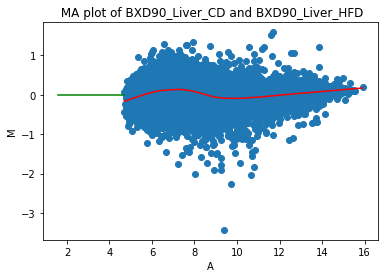

In [14]:
plt.title(' MA plot of BXD90_Liver_CD and BXD90_Liver_HFD')
plt.xlabel('A', fontsize= 10)
plt.ylabel('M', fontsize= 10)
plot1 = ratio_intensity_plot('BXD90_Liver_CD', 'BXD90_Liver_HFD')


This data obviosly has some problems and needs to be normalized.



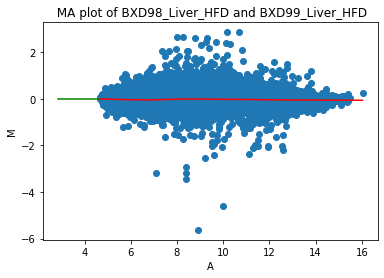

In [15]:
plt.title(' MA plot of BXD98_Liver_HFD and BXD99_Liver_HFD')
plt.xlabel('A', fontsize= 10)
plt.ylabel('M', fontsize= 10)
plot2 = ratio_intensity_plot('BXD98_Liver_HFD', 'BXD99_Liver_HFD')


Most of the data looks very well like this and is not in need of normalisation.



> Implement a RLE plot (RLE = Relative Log Expression)


In [16]:
def rle_plot(df):
    #Substract medians as normalization
    df_subtracted = df.subtract(df.mean(axis=1), axis=0) 
    
    plot = df_subtracted.plot.box(figsize= (15,25), whis = 3, vert=False)
    plt.title('RLE plot')
    plt.ylabel('Gene')
    plt.xlabel('Relative log expression')
    

 > Apply your RLE plot to the data

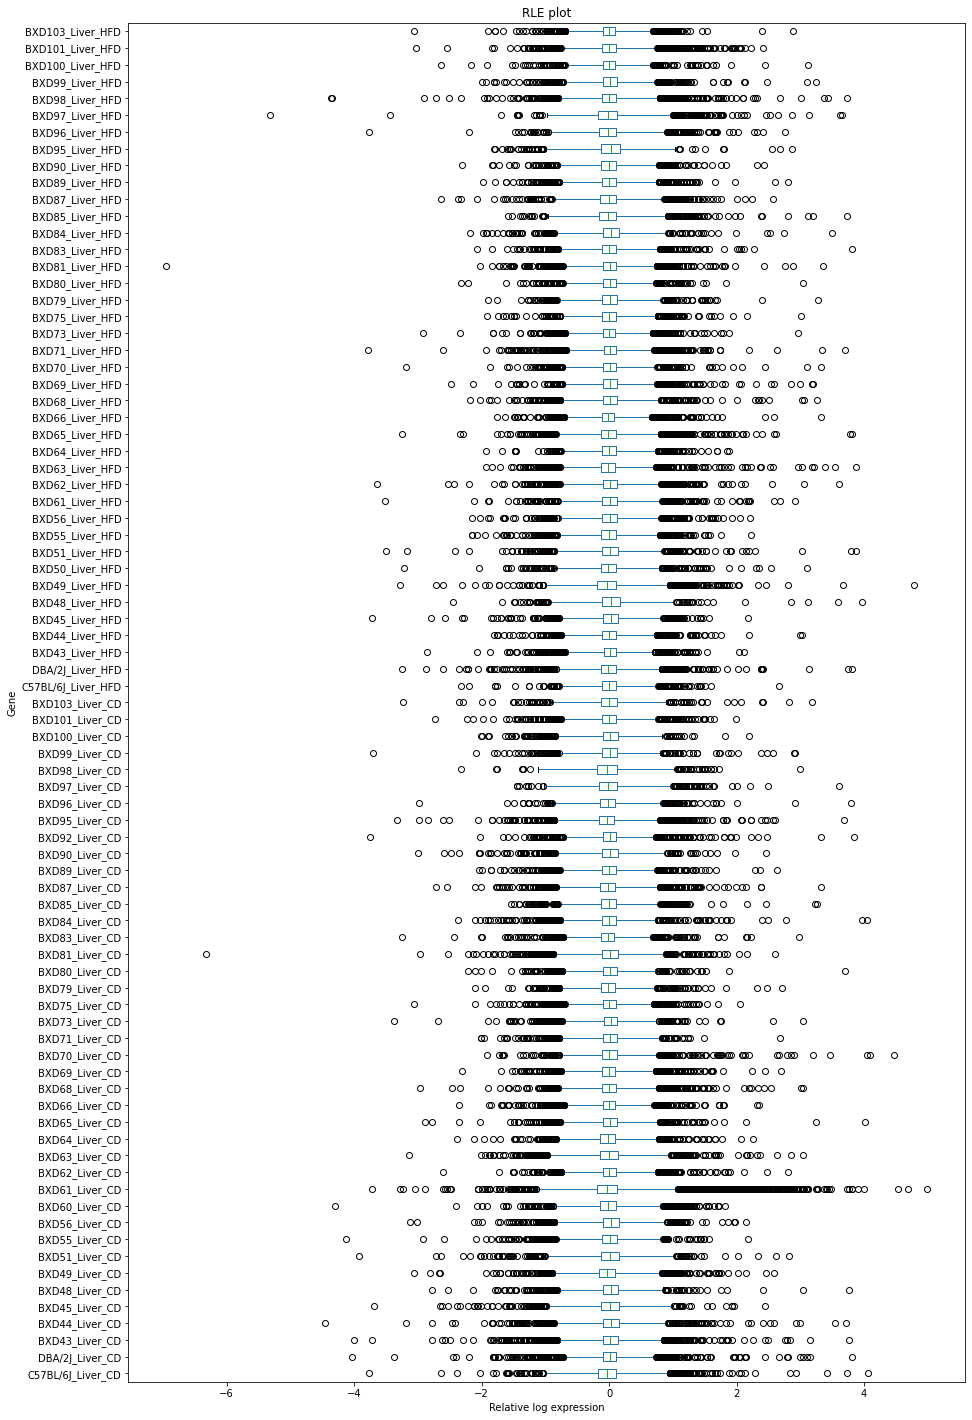

In [17]:
rle_plot(s5grouped_filtered)


Most samples are more or less evenly distributed.



> If you consider it necessary, perform a quantile normalization of the data

I don't consider a quantile normalization as necessary since it is used to make two distributions identical in statistical properties. The RLE plot above shows us that the multiple datasets already are pretty even in their quantiles.



# Chosing a Statistical Test

We want to infer differentially expressed genes between the CD (Control Diet) and the HFD (High Fat Diet) condition. Therefore we (mis)(?)treat (!) the (already) normalized expression values of all the strains for a given condition as independent observations of the same sample. But first we need to figure out which statistical test for differential expression seems appropriate (concerning distribution and variance assumptions) and then apply it. Limit yourself to the Student t-test, the Welch t-test or Wilcoxon's rank-sum test (also sometimes refered to as Whitney-Mann U-test).



## Do the CD and HFD samples have equal variance?

Josef-Francisco Del-Marre-Doyle, famous and visionary president 
of the International BXD Society (IBXDS), just gave a celebrated TED-talk in which he reviewed the fact that any statistic associated with the universe is almost surely normally distributed, and hence you canonically assume that the only thing left to check is whether the samples have equal variance, that is whether to apply Student's or Welch's t-test. Josef-Francisco's assessment usually is that "things are equal" and so you're quite confident that you'll be able to use Student's t-test. But since you're an excellent scientist (and, additionally, won't pass the course otherwise) you still do the following certainly unnecessary work:



> Choose a random row of your latest dataframe using the random module of Python


In [18]:
sample = s5grouped_filtered.iloc[random.randint(0, s5grouped_filtered.shape[1])]
sample.head()

C57BL/6J_Liver_CD    11.309
DBA/2J_Liver_CD      11.416
BXD43_Liver_CD       11.813
BXD44_Liver_CD       11.553
BXD45_Liver_CD       11.481
Name: 1110008F13Rik, dtype: float64

> Make a Q-Q plot comparing the two samples for the just chosen gene and answer the question: Does this tell you anything?

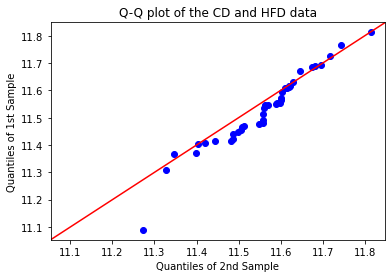

In [19]:
#Split datasets according to diet
samples_cd = sample[sample.index.str.contains("CD")]
samples_hfd = sample[sample.index.str.contains("HFD")]

#For a Q-Q plot the two lists need to have equal length, just delete one entry in the longer list. 
samples_cd = samples_cd[:-1]

smg.qqplot_2samples(samples_cd, samples_hfd, line='45')

plt.title('Q-Q plot of the CD and HFD data')

plt.show()


A Q-Q plot compares two probability distributions for similarity. If the two distributions are similar, the points in the Q–Q plot will approximately lie on the diagonal. Since we are comparing the different expressions of a gene in the CD and HFD mice this will tell us if the gene is similary expressed in the two mice groups or if is it differential expressed. This plot will generate different results based on the randomly chosen gene and for the ones I tested the plot generates various results. Sometimes it evenly expressed in the samples, sometimes stronger in one and weaker in the other.

> Apply an appropriate statistical test in order to figure out whether the samples have equal variance (there may be more than one sensible solution)

In [20]:
z, p = scipy.stats.mood(samples_cd, samples_hfd)
z, p

(0.7256678187127462, 0.4680424346551464)

> To asses the global situation, plot a histogram of p-values for all the genes (using the same test as before)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


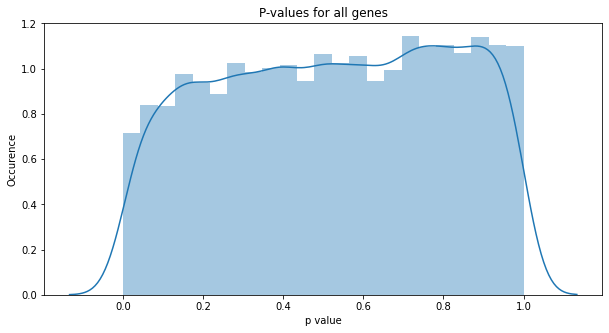

In [21]:
#Skip some of the rows to speed up computations
pvalues = s5grouped_filtered.iloc[::2].apply(lambda x: scipy.stats.mood(x[:40], x[40:])[1], axis = 1)

#Plot as histogram
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(pvalues)

plt.title('P-values for all genes')
plt.xlabel('p value', fontsize= 10)
plt.ylabel('Occurence', fontsize= 10)

plt.show()

The different p-values for the genes in the sample are uniformly distributed, so it is very possible that the two distributions have equal variance.

## Are the CD and HFD samples normally distributed?

Utterly shocked and overwhelmed by ambiguous emotions you begin to doubt the wisdom of Josef-Francisco and start a top-secret and highly dangerous investigation whether the samples are at least normally distributed. Be careful whom you'll tell about that you're working on this...

> Using the same gene randomly chosen above, make a Box plot for the corresponding CD and HFD sample and give an interpretation

Text(0, 0.5, 'Expression values')

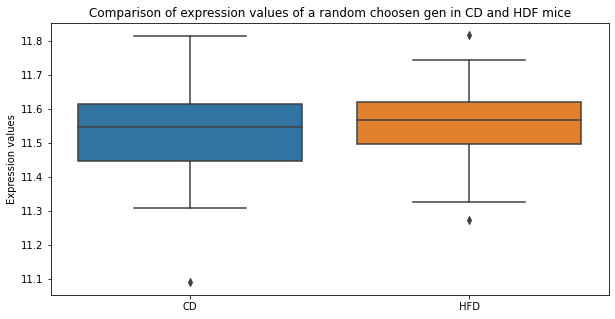

In [22]:
fig, ax = plt.subplots(figsize=(10,5))

bplot = sns.boxplot(data = [samples_cd, samples_hfd])

bplot.set_xticklabels(['CD', 'HFD'])
bplot.set_title('Comparison of expression values of a random choosen gen in CD and HDF mice')
bplot.set_ylabel('Expression values')


Again, this p-value distribution for a random gene from the CD part of the data and the HFD part looks very random.



> Apply an appropriate statistical test in order to figure out whether the samples are normally distributed (there may be more than one sensible solution)

In [23]:
#Use shapiro's test
pvalues_shapiro = s5grouped_filtered.iloc[::20].apply(lambda x: scipy.stats.shapiro(x)[1], axis = 1)

# Check how many pvalues are significant
signi_pvalues = [x for x in pvalues_shapiro if x < 0.01]
len(signi_pvalues)


112

> To asses the global situation, plot a histogram of p-values for all the genes (using the same test before)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


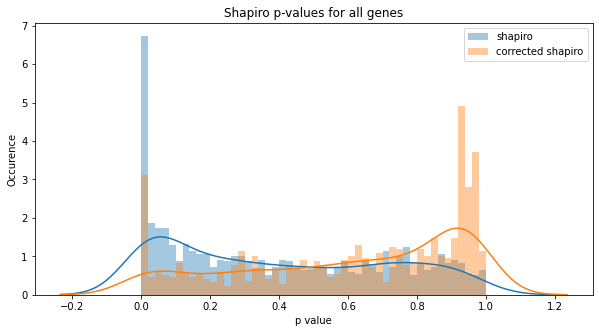

In [24]:
fig, ax = plt.subplots(figsize=(10,5))

#Plot shapiro and corrected shapiro in one plot
sns.distplot(pvalues_shapiro, bins = 50, label = "shapiro")
sns.distplot(multipletests(pvalues_shapiro, method="fdr_bh")[1], bins = 50, label = "corrected shapiro")


plt.title('Shapiro p-values for all genes')
plt.xlabel('p value', fontsize= 10)
plt.ylabel('Occurence', fontsize= 10)

plt.legend()
plt.show()

##  Choose a suitable statistical test to assess differential expression

store the results in a suitable dataframe (you may want to order the genes with respect to their p-values)
and finally extract a list of differentially expressed genes (5% significance).

> Differentially expressed genes

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


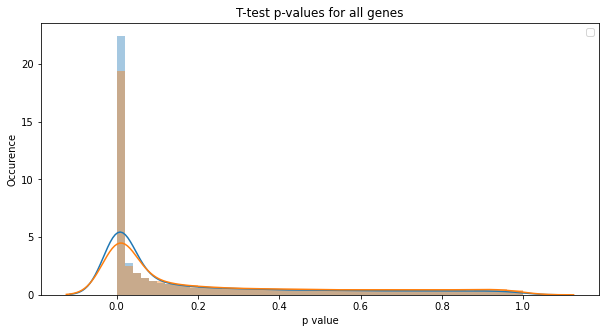

In [25]:
#Use t-test
pvalues_ttest = s5grouped_filtered.iloc[::].apply(lambda x: scipy.stats.ttest_ind(x[:40], x[40:])[1], axis = 1)

#Plot the t-test values and the corrected t-test values
fig, ax = plt.subplots(figsize=(10,5))

sns.distplot(pvalues_ttest, bins = 50)
sns.distplot(multipletests(pvalues_ttest, method="fdr_bh")[1], bins = 50)

plt.title('T-test p-values for all genes')
plt.xlabel('p value', fontsize= 10)
plt.ylabel('Occurence', fontsize= 10)

plt.legend()
plt.show()

Low p-value indicate that almost every gene is differently expressed which is not surprising since its a liver studie. What the t-test doesn't show is the effect size, so it could still be a very small difference.

In [26]:
#Compute number of significant genes

signi_pvalues = [x for x in pvalues_ttest if x < 0.01]
print('Significant genes with raw p values: '+ str(len(signi_pvalues)))

signi_pvalues_corr = [x for x in multipletests(pvalues_ttest, method="fdr_bh")[1] if x < 0.01]
print('Significant genes with corrected p values: '+ str(len(signi_pvalues_corr)))

Significant genes with raw p values: 8786
Significant genes with corrected p values: 7497


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


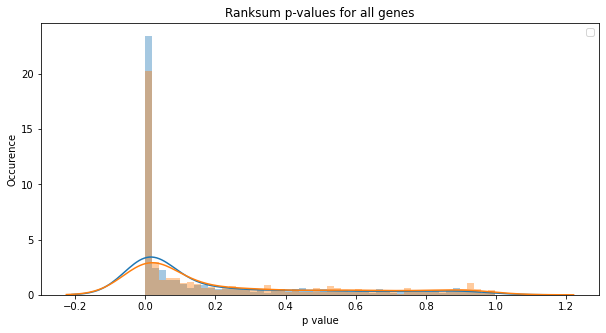

In [27]:
#Check if the results are about the same when using a different method, ranksums

pvalues_ranksums = s5grouped_filtered.iloc[::20].apply(lambda x: scipy.stats.ranksums(x[:40], x[40:])[1], axis = 1)

fig, ax = plt.subplots(figsize=(10,5))

sns.distplot(pvalues_ranksums, bins = 50)

sns.distplot(multipletests(pvalues_ranksums, method="fdr_bh")[1], bins = 50)

plt.title('Ranksum p-values for all genes')
plt.xlabel('p value', fontsize= 10)
plt.ylabel('Occurence', fontsize= 10)

plt.legend()
plt.show()

Using the ranksum test leads to very similar results.



In [28]:
#Compute the fold change of the different expression between cd and hfd
fold_change = s5grouped_filtered.loc[:, samples_cd.index].mean(axis=1) - s5grouped_filtered.loc[:, samples_hfd.index].mean(axis=1)
fold_change


Gene.1
544988          -0.043042
100043387       -0.083700
0610007C21Rik   -0.012175
0610007L01Rik    0.008500
0610007P08Rik   -0.063438
                   ...   
Zzz3             0.144525
a               -0.077325
l7Rn6           -0.108650
mCG_21548       -0.052025
rp9              0.041825
Length: 21835, dtype: float64

# Multiple-testing correction

You receive an anonymous letter revealing to you that you should do multiple-testing correction, otherwise something awfully bad will happen, or not. Puzzled and shaking you embark on this endeavour.

Fredholm, your lab's vodoo priest, is convinced that applying anything else than Bonferroni correction brings death and destruction to the people on the moon. Opportunistically neglecting any potential societal consequences of your actions (technology is neutral after all and who cares about the moon anyway!) you're obsessed to try as many multiple testing procedures as possible.



> Apply all multiple testing procedures you can get your hands on (except Bonferroni; now you should use statsmodels) to your uncorrected p-values and store the results in one (!) dataframe.

In [29]:
#Save all possible methods
correction_methods = ['bonferroni','sidak', 'holm-sidak', 'holm', 'simes-hochberg', 'hommel', 'fdr_bh', 'fdr_by', 'fdr_tsbh', 'fdr_tsbky']

#Create new table for the different p-values, init it with the raw values
pvalues_frame = pd.DataFrame(pvalues_ttest)
pvalues_frame.columns = ['raw_p_values']

#Do the test with every correction method
for method in correction_methods:
    rej, corrected_p_values, _, _ = multitest.multipletests(pvalues_ttest, alpha=0.05, method=method)
    #Add corrected p-values to the dataframe
    pvalues_frame[method] = corrected_p_values


In [30]:
pvalues_frame.head()


,raw_p_values,bonferroni,sidak,holm-sidak,holm,simes-hochberg,hommel,fdr_bh,fdr_by,fdr_tsbh,fdr_tsbky
Gene.1,,,,,,,,,,,
544988,0.011047,1.0,1.0,1.0,1.0,0.999972,0.999972,0.027006,0.285417,0.014607,0.015459
100043387,0.175899,1.0,1.0,1.0,1.0,0.999972,0.999972,0.265337,1.000000,0.143514,0.151889
0610007C21Rik,0.602466,1.0,1.0,1.0,1.0,0.999972,0.999972,0.695288,1.000000,0.376064,0.398010
0610007L01Rik,0.579277,1.0,1.0,1.0,1.0,0.999972,0.999972,0.675813,1.000000,0.365530,0.386862
0610007P08Rik,0.066307,1.0,1.0,1.0,1.0,0.999972,0.999972,0.120020,1.000000,0.064916,0.068704


In [31]:
#Identify number of significant genes according to the methods
(pvalues_frame<0.05).sum()

raw_p_values      11429
bonferroni         2847
sidak              2854
holm-sidak         2912
holm               2901
simes-hochberg     2901
hommel             3003
fdr_bh            10025
fdr_by             6624
fdr_tsbh          11352
fdr_tsbky         11223
dtype: int64

The significant (<0.05) corrected pvalues differ a lot between the correction methods.



## External visual comparison of the different methods

1) use a parallel coordinates plot (see for example Day2_Exploratory_Analysis.ipynb) to visualize the results

2) which of the multiple testing methods is the most stringent? What's the relation between the others?

In [32]:
pvalues_frame = pvalues_frame.reset_index()


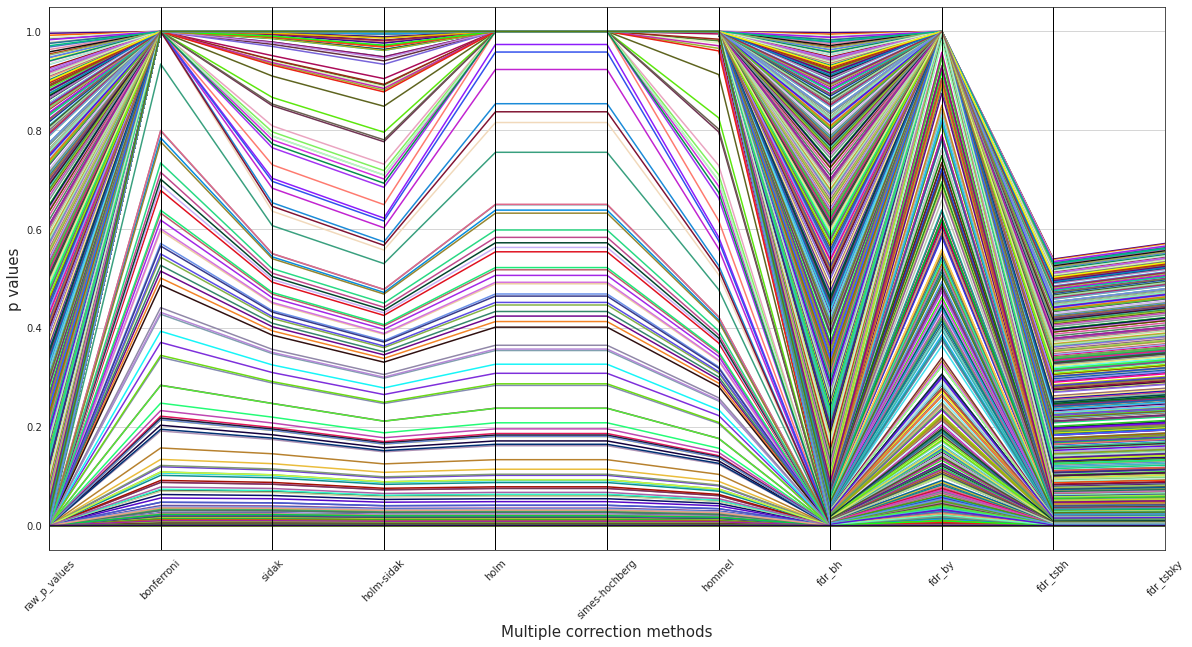

In [33]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, figsize=(20, 10), sharey=True)
    
    parallel_coordinates(pvalues_frame.dropna().iloc[::20], 'Gene.1', ax = ax)

    plt.xticks(rotation=45)

    ax.legend().set_visible(False)
    ax.set_xlabel('Multiple correction methods', fontsize=15)
    ax.set_ylabel('p values', fontsize=15)


With the parallel coordinates plot one can visualize all applied correction methods and their p-values at once. We see that comparing to the raw p values every correction methods produces upregulated values for most of them ( I think this is kind of the thing with correction). We can further see that most of the methods are different in terms of conservaty, except 'holm' and 'simes-hochberg', which have the same results. Bonferroni is together with fdr_by the most conservative method, those two give really high p values back. Benjamini hochberg, fdr_tsbh and fdr_tsbky on the other hand are the most liberal correction methods since many points are still low after the correction (still significant).

# Vulcano plots

> Add a log2 fold change column to the data frame from pvalues_frame and store it as a csv file.

In [34]:
pvalues_frame = pvalues_frame.set_index('Gene.1')

pvalues_frame['fc'] = fold_change

pvalues_frame.head()

,raw_p_values,bonferroni,sidak,holm-sidak,holm,simes-hochberg,hommel,fdr_bh,fdr_by,fdr_tsbh,fdr_tsbky,fc
Gene.1,,,,,,,,,,,,
544988,0.011047,1.0,1.0,1.0,1.0,0.999972,0.999972,0.027006,0.285417,0.014607,0.015459,-0.043042
100043387,0.175899,1.0,1.0,1.0,1.0,0.999972,0.999972,0.265337,1.000000,0.143514,0.151889,-0.083700
0610007C21Rik,0.602466,1.0,1.0,1.0,1.0,0.999972,0.999972,0.695288,1.000000,0.376064,0.398010,-0.012175
0610007L01Rik,0.579277,1.0,1.0,1.0,1.0,0.999972,0.999972,0.675813,1.000000,0.365530,0.386862,0.008500
0610007P08Rik,0.066307,1.0,1.0,1.0,1.0,0.999972,0.999972,0.120020,1.000000,0.064916,0.068704,-0.063438


> Implement a Vulcano plot (from scratch using matplotlib)

In [35]:
def volcano_plot(method):
    
    #Basically just a scatter plot with special axis dimensions
    plt.subplots(figsize=(10,8))
    plt.scatter(x = pvalues_frame['fc'], y = -np.log10(pvalues_frame[method]), alpha=0.5)
    
    #Styling
    plt.axhline(y=1.3, color="r")
    plt.axvline(x=0.5, color="b")
    plt.axvline(x=-0.5, color="b")
    plt.grid(color='tab:gray', linestyle='-', linewidth=0.5)
    plt.xlabel("log fold change", fontsize= 15)
    plt.ylabel("-log10 p", fontsize= 15)
    plt.title("Volcano Plot for "+method, fontsize= 15)
    plt.legend(["Significance Threshold", 'Interesting Foldchange Threshold'])

> Apply your Volcano plot implementation to the uncorrected p-values, as well as the corrected p-values

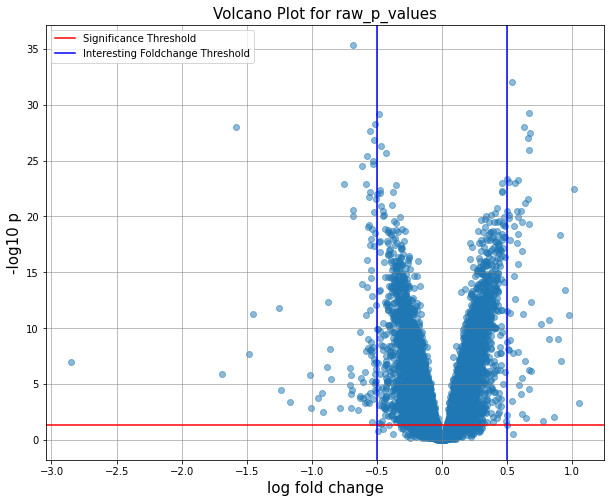

In [36]:
volcano_plot('raw_p_values')

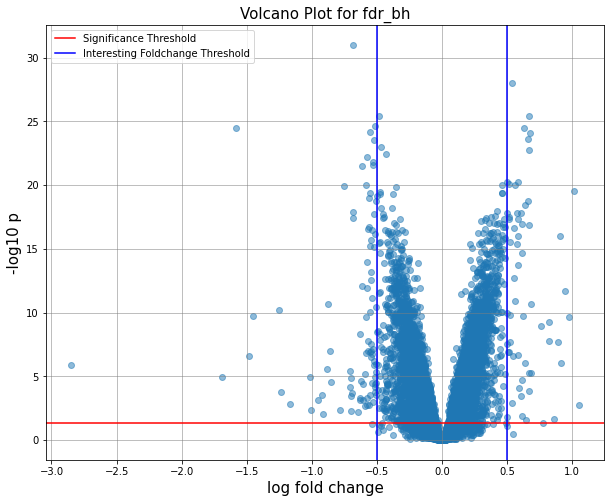

In [37]:
volcano_plot('fdr_bh')


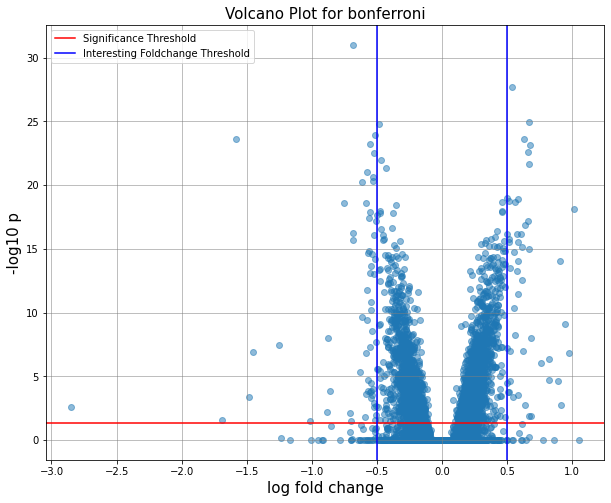

In [39]:
volcano_plot('bonferroni')


Volcano plots in general are most of the times roughly symmetric yet there are exceptions. On the x-axis the different fold changes are plotted, on the y axis the -log10 p value. If we take a look at the previous calculations we will see that our "main" data is the CD dataset, so genes right to x = 0, are upregulated in the CD mice, genes on the left side of x = 0, are downregulated in the CD data. Now, speaking of the y-axis: Here are the different p values plotted. The more significant the gen expression is, the lower its p-value. Therefore, by taking the -log10, former low p values get now high values and the corresponding genes are seen at the top of the plot, while the former high p values are now assigned with low values and stay near the x-axis.

How comes, that some genes present high -log10 p values but low fold change ? Those are candidates which show tight distributions with small variances of their expression values. The two are easy to seperate because of their little spreading but also show little difference in their fold change difference. Genes with low -log10 p value but high fold change differences on the other hand, build somewhat of the opposite. They display wide distributions with high variance and are therefore harder to distinguish, while showing big differences in expression behavior as well.

Which genes are now the most interesting ? To simplify this decision a bit one can add thresholds. A horizontal threshhold (in red), quaranties a certain level of significance and two vertical thresholds (in blue )indicate the borders for a reasonable effect size.

The three volcano plots are for the raw p-values for the liberal correction method benjamin-hochberg and for the conservative correction method bonferroni. The first two plots look a lot similar, but the bonferroni correction plot shows a difference. The "volcano" has a massive base because of the stringent correction of many p values which are not as significant anymore and thus are positioned at the bottom of the plot.

In [40]:
#Identify interesting entrys after the correction and add them to the table:
pvalues_frame['is_interesting'] = (pvalues_frame['fdr_bh'] < 0.05) & (np.abs(pvalues_frame['fc'])>0.25)

pvalues_frame['is_interesting'].sum()

1744

In [41]:
pvalues_frame.to_csv('/content/drive/MyDrive/dataset/BioInformatic/DEanalysis.txt', sep="\t", index = True)
